In [1]:
import tensorflow as tf

2022-03-14 15:27:12.657688: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


2022-03-14 15:27:14.141468: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-14 15:27:14.142633: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-14 15:27:14.184300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-14 15:27:14.184516: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 15 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 2

In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1070


In [4]:
# import the training data into df 
import pandas as pd 

df = pd.read_csv('CSVFiles/training-data-positive-and-negative-sentiment-english.csv')
df = df.drop('Unnamed: 0',axis=1)
df.head()

,Date,text,Sentiment
0,2019-05-27,È appena uscito un nuovo video! LES CRYPTOMONN...,Positive
1,2019-05-27,Cardano: Digitize Currencies; EOS https://t.co...,Positive
2,2019-05-27,Another Test tweet that wasn't caught in the s...,Positive
3,2019-05-27,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,Positive
4,2019-05-27,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,Positive


In [5]:
import matplotlib.pyplot as plt 
import seaborn as sns 

Text(0.5, 0, 'Sentiment Score')

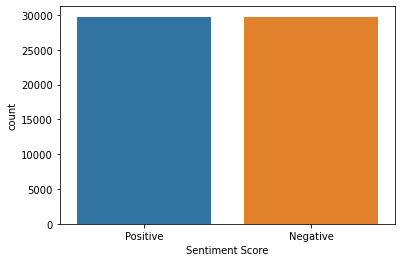

In [6]:
sns.countplot(x=df.Sentiment)
plt.xlabel('Sentiment Score')

In [7]:
# install hugging face library to use their transformers package 
!pip install huggingface

In [8]:
print('Number of training sentences: {:,}\n'.format(df.shape[0])) # we have 10,006 total sentences 

Number of training sentences: 59,500



In [9]:
# df = df.replace({'Sentiment': {'Negative':int(0), 'Neutral':int(1), 'Positive':int(2)}})  
encoded_label = {'Negative': 0, 'Positive': 1}
df['Sentiment'] = df['Sentiment'].map(encoded_label)
df.sample(10)

,Date,text,Sentiment
19602,2019-05-27,"ビットコイン・スプレッド・アラート\n（BID）956,588円 Liquid\n（ASK）...",1
59087,2019-05-21,New post: Lambo-Lusting Britons Lose $34 Milli...,0
43882,2019-05-21,Bitcoin Wallets in 2014 via /r/Bitcoin https:/...,0
41101,2019-05-21,CyberMiles/#bitcoin 21 May #CMT $CMT #BTC $BTC...,0
7981,2019-05-27,I'm convinced that XRP is in a bull market and...,1
25586,2019-05-27,$BCPT 🔻 -153 -15.66% 🕐 in the last 24 hours 💵...,1
40686,2019-05-21,Coinbase the best Bitcoin wallet - #guadagno #...,0
17348,2019-05-27,スペイン人に大人気な富士コイン。\nhttps://t.co/Q2ZGa26WHM ##Fu...,1
40563,2019-05-21,The U.S. Securities and Exchange Commission (@...,0
53492,2019-05-21,#bitcoin #btc #Crypto $crypto\ntake care to be...,0


In [10]:
# !pip install transformers
# now we want to format our data so that VERT can use it for training 
from transformers import BertTokenizer 

# load the BERT tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [11]:
# some regex to clean the data before passing it to BERT tokenizer  
import re 
df = df.replace(to_replace='https?:\/\/\S+', value='', regex=True) # remove https urls 
df = df.replace(to_replace="www\.[a-z]?\.?(com)+|[a-z]+\.(com)", value='', regex=True) # remove www urls 
df = df.replace(to_replace="\[video\]", value='', regex=True) # remove videos that got replaced with [video]
df = df.replace(to_replace='{link}', value='', regex=True) # remove links 
df = df.replace(to_replace='&[a-z]+;', value='', regex=True) # remove HTML embedded characters
df = df.replace(to_replace='@[^ ]+', value='', regex=True) # remove @usernames 

# some sample output 
tweets = df.text.values 
labels = df.Sentiment.values 
# import numpy as np
# labels = np.array(labels)

print(' Original: ', tweets[0])
print('Tokenized: ', tokenizer.tokenize(tweets[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[0])))

 Original:  È appena uscito un nuovo video! LES CRYPTOMONNAIES QUI PULVÉRISENT BITCOIN EN 2019 
Tokenized:  ['e', 'app', '##ena', 'usc', '##ito', 'un', 'nu', '##ovo', 'video', '!', 'les', 'crypt', '##omo', '##nna', '##ies', 'qui', 'pu', '##lver', '##isen', '##t', 'bit', '##co', '##in', 'en', '2019']
Token IDs:  [1041, 10439, 8189, 15529, 9956, 4895, 16371, 16059, 2678, 999, 4649, 19888, 19506, 9516, 3111, 21864, 16405, 26229, 28992, 2102, 2978, 3597, 2378, 4372, 10476]


In [12]:
# df = df.drop(['Unnamed: 0'],axis=1)
# df

KeyError: "['Unnamed: 0'] not found in axis"

In [13]:
max_len = 0 

for i in range(len(tweets)):
    # tokenize the text and add `[CLS]` and `[SEP]` tokens 
    input_ids = tokenizer.encode(str(tweets[i]), add_special_tokens=True)
    
    #update max sentence length
    max_len = max(max_len, len(input_ids))
    
print('max sentence length: ', max_len)

max sentence length:  226


In [14]:
# we will set max_len to 235 
# now we can perform tokenization 
input_ids = [] 
attention_masks = [] 

for i in range(len(tweets)):
    encoded_dict = tokenizer.encode_plus(
                        str(tweets[i]),                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    # add encoded sentence to list 
    input_ids.append(encoded_dict['input_ids'])
    # add attention masks to list 
    attention_masks.append(encoded_dict['attention_mask'])
    
#convert the lists into tensors 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', tweets[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/phil81/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  È appena uscito un nuovo video! LES CRYPTOMONNAIES QUI PULVÉRISENT BITCOIN EN 2019 
Token IDs: tensor([  101,  1041, 10439,  8189, 15529,  9956,  4895, 16371, 16059,  2678,
          999,  4649, 19888, 19506,  9516,  3111, 21864, 16405, 26229, 28992,
         2102,  2978,  3597,  2378,  4372, 10476,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [15]:
# we will not divide our training data into training and validation sets (90/10)
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

In [16]:
# set batch size to 32 for fine-tuning BERT 
batch_size = 32 

# combine training inputs into a training dataset 
dataset = TensorDataset(input_ids, attention_masks, labels)

training_size = int(0.9*len(dataset))
validation_size = len(dataset) - training_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [training_size, validation_size])

print('{:>5,} training samples'.format(training_size))
print('{:>5,} validation samples'.format(validation_size))
# THIS CONCLUDES PROCESSING OUR DATA FOR TRAINING 
# https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=6J-FYdx6nFE_ 

# create an iterator for our dataset using the torch DataLoader class, saving on memory during training and boost training speed 
train_dataloader = DataLoader(train_dataset, 
                                 sampler=RandomSampler(train_dataset), 
                                 batch_size=batch_size)
validation_dataloader = DataLoader(val_dataset, 
                                   sampler=RandomSampler(val_dataset), 
                                   batch_size=batch_size)

53,550 training samples
5,950 validation samples


In [17]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels    = 2, 
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [18]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [19]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/home/phil81/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [21]:
# Define a helper function for calculating accuracy.
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [22]:
# Helper function for formatting elapsed times as `hh:mm:ss`
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [23]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True
                      )

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,674.    Elapsed: 0:00:13.
  Batch    80  of  1,674.    Elapsed: 0:00:26.
  Batch   120  of  1,674.    Elapsed: 0:00:39.
  Batch   160  of  1,674.    Elapsed: 0:00:51.
  Batch   200  of  1,674.    Elapsed: 0:01:04.
  Batch   240  of  1,674.    Elapsed: 0:01:17.
  Batch   280  of  1,674.    Elapsed: 0:01:30.
  Batch   320  of  1,674.    Elapsed: 0:01:43.
  Batch   360  of  1,674.    Elapsed: 0:01:56.
  Batch   400  of  1,674.    Elapsed: 0:02:09.
  Batch   440  of  1,674.    Elapsed: 0:02:22.
  Batch   480  of  1,674.    Elapsed: 0:02:35.
  Batch   520  of  1,674.    Elapsed: 0:02:47.
  Batch   560  of  1,674.    Elapsed: 0:03:00.
  Batch   600  of  1,674.    Elapsed: 0:03:13.
  Batch   640  of  1,674.    Elapsed: 0:03:26.
  Batch   680  of  1,674.    Elapsed: 0:03:39.
  Batch   720  of  1,674.    Elapsed: 0:03:52.
  Batch   760  of  1,674.    Elapsed: 0:04:05.
  Batch   800  of  1,674.    Elapsed: 0:04:18.
  Batch   840  of

  Batch 1,560  of  1,674.    Elapsed: 0:08:23.
  Batch 1,600  of  1,674.    Elapsed: 0:08:36.
  Batch 1,640  of  1,674.    Elapsed: 0:08:49.

  Average training loss: 0.29
  Training epcoh took: 0:09:00

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.57
  Validation took: 0:00:18

Training complete!
Total training took 0:37:33 (h:mm:ss)


In [24]:
df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.564585,0.487405,0.717977,0:09:12,0:00:18
2,0.433152,0.463959,0.741689,0:09:03,0:00:18
3,0.347292,0.500039,0.747905,0:09:07,0:00:18
4,0.285143,0.574535,0.751232,0:09:00,0:00:18


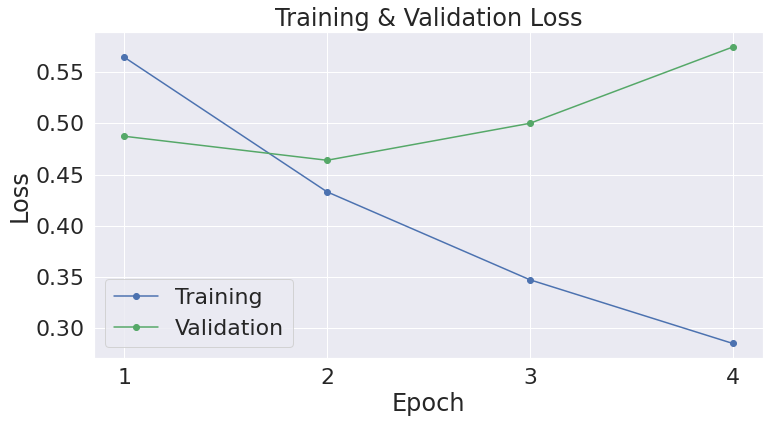

In [25]:
sns.set(style='darkgrid')

sns.set(font_scale=2.0)
plt.rcParams["figure.figsize"]=(12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [33]:
# dfsample = pd.read_csv('CSVFiles/training-data-positive-negative.csv')
# encoded_label = {'Negative': 0, 'Positive': 1}
# dfsample['Sentiment'] = dfsample['Sentiment'].map(encoded_label)
# dfsample = dfsample.drop(['Unnamed: 0'], axis=1)
dfsample = df.sample(n=5000, ignore_index=True)
dfsample

,Date,text,Sentiment
0,2019-05-27,"💳 40,000 BTR #CONTEST 💳💥\n💥 BITRUE COIN EXCHA...",1
1,2019-05-21,#QKC #Blockchain #BTC #ETH #blockchaintechnolo...,0
2,2019-05-21,フェイスブックにウォレット機能がつくのかぁ。業界にとってはビックニュースだけど、もう単なるウ...,0
3,2019-05-21,昨日は狙ったとこでSでとれたが、今日はレンジでつまらない。\n$BTC\n$XRP,0
4,2019-05-21,Sub #Five_Fricking_Digits( )\n\nSelect Poll_Re...,0
...,...,...,...
4995,2019-05-21,【独証券取引所にXRPとLTC連動ETN上場👋🏻】\n\nドイツ2位証券取引所、ベールゼ・シ...,0
4996,2019-05-21,#crypto #blockchain #coin #ethereum #erc20 #...,0
4997,2019-05-21,Just got into two NEW trades! Flash trades on ...,0
4998,2019-05-21,Lets You Send BTC to a Friend via Their Phone...,0


In [34]:
tweets = dfsample.text.values 
labels = dfsample.Sentiment.values 

input_ids = [] 
attention_masks = [] 

for i in range(len(tweets)): 
    encoded_dict = tokenizer.encode_plus(
        str(tweets[i]),
        add_special_tokens = True, 
        max_length = 64, 
        pad_to_max_length=True, 
        return_attention_mask = True, 
        return_tensors = 'pt',
    )
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/home/phil81/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [35]:
# evaluate on our test set 
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# put model in evaluation mode 
model.eval()

# variables for tracking labels 
predictions, true_labels = [], []

for batch in prediction_dataloader:
    # add batch to GPU 
    batch = tuple(t.to(device) for t in batch)
    
    # unpack inputs from dataloader 
    b_input_ids, b_input_mask, b_labels = batch 
    
    # tell model to not compute/store gradients 
    # saves memory and speeds up transaction 
    with torch.no_grad():
        # forward pass 
        result = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask = b_input_mask,
                      return_dict=True)
        
    logits = result.logits 
    # move logits and labels to CPU 
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
        
    predictions.append(logits)
    true_labels.append(label_ids)
    
print('DONE')


Predicting labels for 5,000 test sentences...
DONE


In [36]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

for i in range(len(true_labels)):
    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


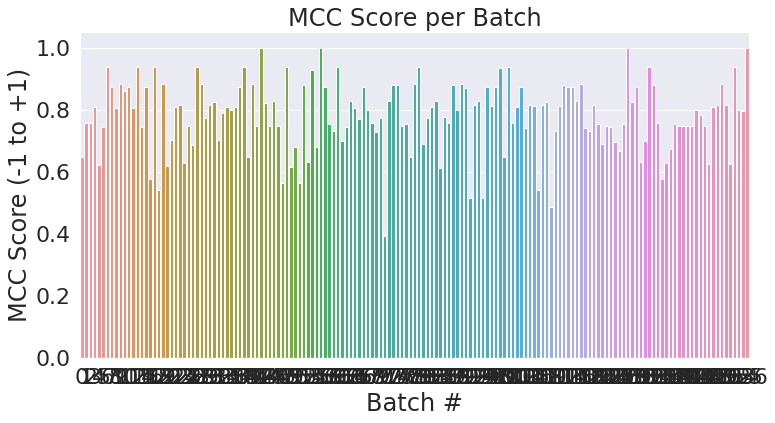

In [37]:
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [38]:
print('Positive samples: %d of %d (%.2f%%)' % (dfsample.Sentiment.sum(), len(dfsample.Sentiment), (dfsample.Sentiment.sum() / len(dfsample.Sentiment) * 100.0)))

Positive samples: 2478 of 5000 (49.56%)


In [39]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.778
